Celeb Faces Dataset (CelebA)
=================================================
---
Introduction au Deep Learning  (IDLE) - S. Arias, E. Maldonado, JL. Parouty - CNRS/SARI/DEVLOG - 2020  

We'll do the same thing again but with a more interesting dataset:  CelebFaces  
About this dataset : http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

## Episode 1 : Preparation of data

 - Understanding the dataset
 - Preparing and formatting enhanced data
 - Save enhanced datasets in h5 file format


## Step 1 - Import and init
### 1.2 - Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io, transform

import os,time,sys,json,glob
import csv
import math, random

from importlib import reload

sys.path.append('..')
import fidle.pwk as ooo

ooo.init()


FIDLE 2020 - Practical Work Module
Version              : 0.2.7
Run time             : Monday 10 February 2020, 20:31:30
TensorFlow version   : 2.2.0-dev20200122
Keras version        : 2.2.4-tf


In [12]:
os.getenv('WORK', '')

'/gpfswork/rech/mlh/uja62cb'

### 1.2 - Directories and files :
Because the world is big and you can be here or there...

In [15]:
# ---- Possible dataset directories
#
places={ 'GRICAD' : '/bettik/PROJECTS/pr-fidle/datasets/celeba',
         'IDRIS'  : f'{os.getenv("WORK","")}/datasets/celeba'
       }

# ---- Check the good place
for dataset_place,dataset_dir in places.items():
    if os.path.isdir(dataset_dir): break

## Step 2 - Understanding the dataset

### 2.1 - Read the catalog file

In [16]:
dataset_csv = f'{dataset_dir}/list_attr_celeba.csv'
dataset_img = f'{dataset_dir}/img_align_celeba'

# ---- Read dataset attributes

dataset_desc = pd.read_csv(dataset_csv, header=0)

# ---- Have a look

display(dataset_desc.head(10))

print(f'\nDonnées manquantes : {dataset_desc.isna().sum().sum()}')
print(f'dataset_desc.shape : {dataset_desc.shape}')

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
5,000006.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,1,-1,1,-1,-1,1
6,000007.jpg,1,-1,1,1,-1,-1,1,1,1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,1
7,000008.jpg,1,1,-1,1,-1,-1,1,-1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
8,000009.jpg,-1,1,1,-1,-1,1,1,-1,-1,...,-1,1,-1,-1,1,-1,1,-1,-1,1
9,000010.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,1,-1,-1,1



Données manquantes : 0
dataset_desc.shape : (202599, 41)


### 2.2 - Load 1000 images

In [19]:
start_time = time.time()

nb_images=1000
filenames = [ f'{dataset_img}/{i}' for i in dataset_desc.image_id[:nb_images] ]
x=[]
for filename in filenames:
    image=io.imread(filename)
    x.append(image)
    ooo.update_progress("1000 images :",len(x),nb_images)
x_data=np.array(x)
x=None
    
duration=time.time()-start_time
reload(ooo)
print(f'\nDuration   : {duration:.2f} s')
print(f'Shape is   : {x_data.shape}')
print(f'Numpy type : {x_data.dtype}')

ooo.display_md('<br>**Note :** Estimation for **200.000** normalized images : ')
x_data=x_data/255
print(f'Charging time : {200*duration:.2f} s or {ooo.hdelay(200*duration)}')
print(f'Numpy type    : {x_data.dtype}')
print(f'Memory size   : {ooo.hsize(200*x_data.nbytes)}')

1000 images :    [########################################] 100.0% of 1000

Duration   : 1.15 s
Shape is   : (1000, 218, 178, 3)
Numpy type : uint8


<br>**Note :** Estimation for **200.000** normalized images : 

Charging time : 230.59 s or 0:03:50
Numpy type    : float64
Memory size   : 173.5 Go


## Step 3 - Have a look

### 3.1 - Few statistics
We want to know if our images are homogeneous in terms of size, ratio, width or height.

In [20]:
data_size  = []
data_ratio = []
data_lx    = []
data_ly    = []

for image in x_data:
    (lx,ly,lz) = image.shape
    data_size.append(lx*ly/1024)
    data_ratio.append(lx/ly)
    data_lx.append(lx)
    data_ly.append(ly)

df=pd.DataFrame({'Size':data_size, 'Ratio':data_ratio, 'Lx':data_lx, 'Ly':data_ly})
display(df.describe().style.format("{0:.2f}").set_caption("About our images :"))
    

,Size,Ratio,Lx,Ly
count,1000.00,1000.00,1000.00,1000.00
mean,37.89,1.22,218.00,178.00
std,0.00,0.00,0.00,0.00
min,37.89,1.22,218.00,178.00
25%,37.89,1.22,218.00,178.00
50%,37.89,1.22,218.00,178.00
75%,37.89,1.22,218.00,178.00
max,37.89,1.22,218.00,178.00


### 3.2 - What does it really look like

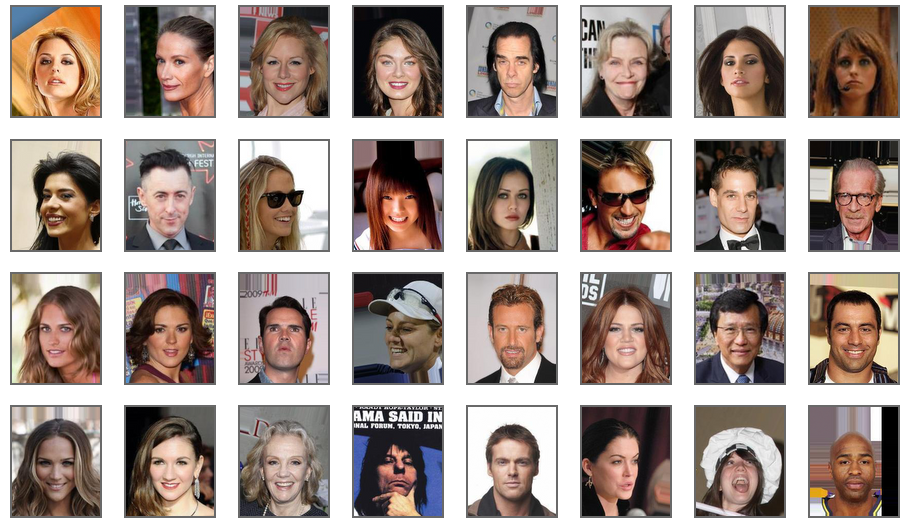

In [21]:
samples = [ random.randint(0,len(x_data)-1) for i in range(32)]
ooo.plot_images(x_data, indices=samples, columns=8, x_size=2, y_size=2)

<div class=warn>
Fine ! :-)<br>But how can we effectively use this dataset, considering its size and the number of files ?<br>
We're talking about a 10' of loading time and 170 GB of data... ;-(<br>
...and on top of that, the size of the pictures will make life difficult for us !
<div/>

## Step 4 - Save as clusters of n images

In order to avoid reading multiple files of very small size, we will group our images in large npy files.  
We will proceed as follows:  
 - we're gonna shuffle our catalog,
 - we're going to create an save clusters of n resized images,
 - 80% of these clusters will be used for training,
 - 20 % for test/validation

### 4.1 - Shuffle catalog 

In [22]:
dataset_desc = dataset_desc.reindex(np.random.permutation(dataset_desc.index))
display(dataset_desc.head(10))

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
196024,196025.jpg,-1,-1,-1,-1,1,-1,-1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
196472,196473.jpg,-1,-1,-1,-1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,-1
184566,184567.jpg,1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
80335,080336.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
149987,149988.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
122714,122715.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,1,1
36550,036551.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,1,-1,-1,1
155641,155642.jpg,-1,-1,-1,-1,-1,-1,1,-1,1,...,-1,-1,1,-1,1,-1,1,-1,-1,1
32842,032843.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
124526,124527.jpg,1,-1,1,1,-1,-1,-1,1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1,1


### 4.2 - A nice function :
Who will read the .jpg images and build the clusters files, with :
 - **dataset_img** : The folder where the .jgp images are located.
 - **dataset_desc** : A Pandas DataFrame with the list of images and associated attributes
 - **cluster_size** : Cluster size (ie number of images per cluster)
 - **cluster_dir** : Where to put the cluster files
 - **cluster_name** : Cluster files name

In [23]:
def read_and_save( dataset_img, dataset_desc, 
                   cluster_size=1000, cluster_dir='./dataset_cluster', cluster_name='images',
                   image_size=(128,128)):
    
    def save_cluster(imgs,desc,cols,id):
        file_img  = f'{cluster_dir}/{cluster_name}-{id:03d}.npy'
        file_desc = f'{cluster_dir}/{cluster_name}-{id:03d}.csv'
        np.save(file_img,  np.array(imgs))
        df=pd.DataFrame(data=desc,columns=cols)
        df.to_csv(file_desc, index=False)
        return [],[],id+1
    
    start_time = time.time()
    cols = list(dataset_desc.columns)

    # ---- Check if cluster files exist
    #
    if os.path.isfile(f'{cluster_dir}/images-000.npy'):
        print('\n*** Oops. There are already clusters in the target folder!\n')
        return 0,0
    
    # ---- Create cluster_dir
    #
    os.makedirs(cluster_dir, mode=0o750, exist_ok=True)
    
    # ---- Read and save clusters
    #
    imgs, desc, cluster_id = [],[],0
    #
    for i,row in dataset_desc.iterrows():
        #
        filename = f'{dataset_img}/{row.image_id}'
        #
        # ---- Read image, resize (and normalize)
        #
        img = io.imread(filename)
        img = transform.resize(img, image_size)
        #
        # ---- Add image and description
        #
        imgs.append( img )
        desc.append( row.values )
        #
        # ---- Progress bar
        #
        ooo.update_progress(f'Cluster {cluster_id:03d} :',len(imgs),cluster_size)
        #
        # ---- Save cluster if full
        #
        if len(imgs)==cluster_size:
            imgs,desc,cluster_id=save_cluster(imgs,desc,cols, cluster_id)

    # ---- Save uncomplete cluster
    if len(imgs)>0 : imgs,desc,cluster_id=save_cluster(imgs,desc,cols,cluster_id)

    duration=time.time()-start_time
    return cluster_id,duration


### 4.3 - Cluster building
Reading the 200,000 images can take up to 20 minutes.  
190,000 images will be used for training (x_train), the rest for validation (x_test)  
The 21 clusters will represent about 21 GB.  
If the target folder is not empty, the construction is blocked.

In [ ]:
# ---- Cluster size

cluster_size_train = 10000
cluster_size_test  = 10000
image_size         = (128,128)

# ---- Clusters location

train_dir  = f'{dataset_dir}/clusters.train'
test_dir   = f'{dataset_dir}/clusters.test'

# ---- x_train, x_test
#
n1,d1 = read_and_save(dataset_img, dataset_desc[:200000],
                      cluster_size = cluster_size_train, 
                      cluster_dir  = train_dir,
                      image_size   = image_size )

n2,d2 = read_and_save(dataset_img, dataset_desc[200000:],
                      cluster_size = cluster_size_test, 
                      cluster_dir  = test_dir,
                      image_size   = image_size )
        
print(f'\n\nDuration : {d1+d2:.2f} s or {ooo.hdelay(d1+d2)}')
print(f'Train clusters : {train_dir}')
print(f'Test  clusters : {test_dir}')

Cluster 000 :    [########################################] 100.0% of 10000
Cluster 001 :    [########################################] 100.0% of 10000


----
That's all folks !